In [1]:
import numpy as np
import pandas as pd

np.random.seed(27)

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.__version__)

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

Num GPUs Available:  1
2.3.0


# Set up OpenAQ, Meteostat APIs

OpenAQ: https://openaq.org/
MeteoStat: https://meteostat.net/en

Tools
py-openaq: https://github.com/dhhagan/py-openaq
meteostat: https://dev.meteostat.net/python/

In [2]:
import openaq
# Import Meteostat library and dependencies
from meteostat import Point, Hourly, Daily

openaq = openaq.OpenAQ(version="v2")

## Get data from OpenAQ

In [3]:
class Location:
    def __init__(self, name, lat, lon):
        self.name = name
        self.lat = lat
        self.lon = lon


locations_UK = []

cities = openaq.cities(country="GB", limit=100000, df=True)["city"]

for city in cities:
    print(city)
    try:
        res = openaq.locations(city=city, df=True)[["coordinates.latitude","coordinates.longitude"]].mean()
    
        locations_UK.append(Location(city, res["coordinates.latitude"], res["coordinates.longitude"]))
    except:
        print("-----------Skipped {}-----------".format(city))
    
# cities available pollutants
# ΑΤΤΙΚΗ - ['pm25','pm10','o3''so2','co'],
# ΔΥΤΙΚΗ ΕΛΛΑΔΑ - ['pm25','pm10','so2','co','no2'],
# ΘΕΣΣΑΛΙΑ - ['pm25','pm10'],
# ΚΕΝΤΡΙΚΗ ΜΑΚΕΔΟΝΙΑ - ['pm25','pm10','no2','o3''so2','co']
# ΣΤΕΡΕΑ ΕΛΛΑΔΑ - ['pm25','pm10','so2','no2','o3']

Aberdeen
Armagh
Aston Hill
Auchencorth
Ballymena
Barnsley
Barnstaple
Bath
Belfast
Billingham
Birmingham
Blackburn
Blackpool
Bottesford
Bournemouth
Bradford
Brighton
Bristol
Bury
Bush Estate
Cambridge
Canterbury
Cardiff
Carlisle
Central Scotland
Charlton
Chatham
Chepstow
Chesterfield
Coventry
Crompton Way   OL2 8AQ
Derby
Derry
Doncaster
Dumbarton
Dumfries
Eastbourne
Edinburgh
Eskdalemuir
Exeter
Fort William
Glasgow
Glazebury
Grangemouth
Great Dun Fell
High Muffles
Honiton
Horley
Hull
Inverness
Ladybower
Leamington Spa
Leeds
Leicester
Leominster
Lerwick
Lincoln
Liverpool
London
Lough Navar
Lullington Heath
Luton
Mace Head
Manchester
Market Harborough
Middlesbrough
Narberth
Newcastle
Newport
Northampton
North West & Merseyside
-----------Skipped North West & Merseyside-----------
Norwich
Nottingham
Oldbury
Oxford
Peebles
Plymouth
Portsmouth
Port Talbot
Preston
Reading
Rochester
Saltash
Sandy
Scunthorpe
Sheffield
Sibton
Southampton
South East
South West
Stanford-le-Hope
Stockbridge
Stockto

In [4]:
from datetime import datetime, timedelta
import time

# We will select London because it holds most sensors
selected_location = locations_UK[58]
print(selected_location.name)
# Format coordinates to align with OpenAQ standards
coordinates = "{},{}".format(round(selected_location.lat, 8), round(selected_location.lon, 8))

now = datetime(2021,10,1)

# For some reason the OpenAQ API accepts the date only in this way
date_from = datetime(2020 , 5, 10)
date_to = datetime(now.year, now.month, now.day) + timedelta(days=1)

print("Time Range: {} - {}".format(date_from, date_to))

selected_pollutants = ['pm25','pm10','no2','o3','so2']

# Create empty Dataframe
df_pollutants = pd.DataFrame(columns=selected_pollutants)

# getPollutants()

for pollutant in selected_pollutants:
    locations = openaq.locations(coordinates=coordinates, parameter=pollutant, radius=20000, df=True, has_geo=True)

    dfs_array = []
    for location in locations["id"]:
        try:
            time.sleep(3)
            df = openaq.measurements(location=location,
                                     date_from=date_from.date(), 
                                     date_to=date_to.date(),
                                     limit=100000, 
                                     parameter=pollutant,
                                     df=True,
                                     sort="asc")[["value"]].resample('H').mean()
            
            dfs_array.append(df)
            print("Added location {}".format(location))
        
        except:
            print("Skipped location {}".format(location))
    
    dfs_array = sorted(dfs_array,key=lambda x:x.index[0])
    df_pollutants[pollutant] = pd.concat(dfs_array, join="outer", axis = 1, sort=False).mean(axis=1)
    print("Added pollutant {}".format(pollutant))
    print("---------------------")

print("Data fetching completed!")

df_pollutants

London
Time Range: 2020-05-10 00:00:00 - 2021-10-02 00:00:00
Skipped location 73049
Skipped location 225379
Skipped location 65995
Skipped location 222799
Skipped location 225380
Skipped location 60
Added location 148
Added location 154
Added location 155
Added location 225723
Added location 225737
Added location 225743
Added location 225763
Added location 225770
Added location 225772
Added location 225790
Added location 225842
Added location 227058
Added location 152
Added location 218321
Added location 223691
Added location 223693
Added location 223694
Added location 223695
Added location 223696
Added location 223703
Added location 223704
Added location 223707
Added location 223710
Added location 223713
Added location 223718
Added location 223723
Added location 223724
Added location 223727
Added location 223728
Added location 223729
Added location 223730
Added location 223737
Added location 223739
Added location 223740
Added location 223741
Added location 223743
Added location 223753

,pm25,pm10,no2,o3,so2
date.local,,,,,
2020-05-10 01:00:00,16.306458,32.800000,31.402186,106.500000,4.333333
2020-05-10 02:00:00,15.909375,32.500000,26.201515,105.666667,4.000000
2020-05-10 03:00:00,16.222708,32.000000,27.301617,101.333333,5.500000
2020-05-10 04:00:00,16.411042,31.250000,23.601511,98.333333,5.500000
2020-05-10 05:00:00,17.006327,30.400000,21.637600,93.500000,4.666667
...,...,...,...,...,...
2021-10-01 21:00:00,7.700000,15.710714,39.036585,30.576471,2.900000
2021-10-01 22:00:00,6.194737,15.702564,35.688312,30.500000,2.650000
2021-10-01 23:00:00,4.000000,11.000000,30.000000,37.000000,2.000000


array([<AxesSubplot:xlabel='date.local'>,
       <AxesSubplot:xlabel='date.local'>,
       <AxesSubplot:xlabel='date.local'>,
       <AxesSubplot:xlabel='date.local'>,
       <AxesSubplot:xlabel='date.local'>], dtype=object)

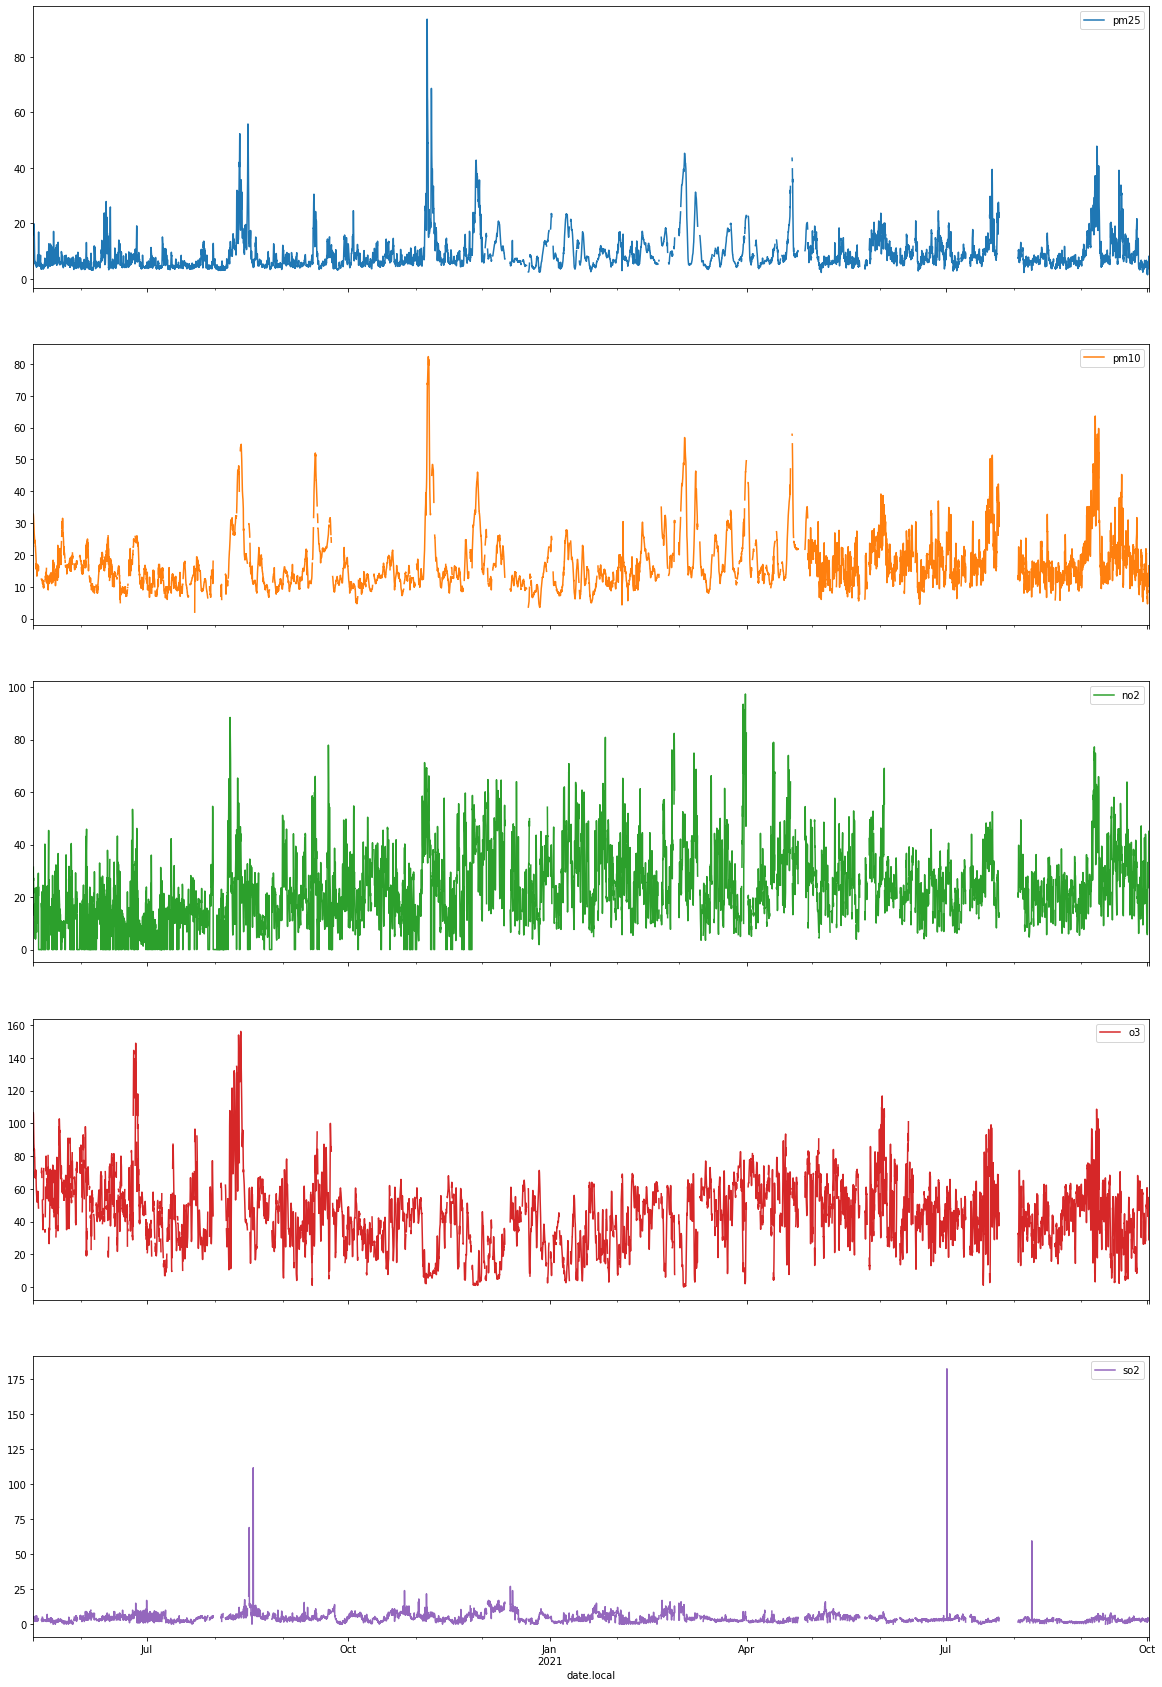

In [5]:
df_pollutants.plot(figsize=(20,30), subplots=True)

In [6]:
# Create Point for London
# We will give the median between the maximum: 245m, minimum: 0m elevation of London 

loc = Point(selected_location.lat, selected_location.lon, 72)

# temp  The air temperature in °C
# dwpt  The dew point in °C
# rhum  The relative humidity in percent (%)
# prcp  The one hour precipitation total in mm
# snow  The snow depth in mm
# wdir  The average wind direction in degrees (°)
# wspd  The average wind speed in km/h
# wpgt  The peak wind gust in km/h
# pres  The average sea-level air pressure in hPa
# tsun  The one hour sunshine total in minutes (m)
# coco  The weather condition code

# Get hourly data
df_weather = Hourly(loc=loc, start=date_from, end=date_to)
df_weather = df_weather.normalize()
df_weather = df_weather.fetch()

# Remove columns that hold no values
weather_features = ['dwpt', 'prcp', 'snow', 'wdir', 'wpgt', 'tsun']
df_weather.drop(weather_features, axis=1, inplace=True)
# df_weather = df_weather.interpolate(method='time')

final_df = df_pollutants.merge(df_weather, left_index=True, right_index=True)

final_df

,pm25,pm10,no2,o3,so2,temp,rhum,wspd,pres,coco
2020-05-10 01:00:00,16.306458,32.800000,31.402186,106.500000,4.333333,11.1,76.4,3.1,1007.9,3.0
2020-05-10 02:00:00,15.909375,32.500000,26.201515,105.666667,4.000000,10.3,80.9,4.7,1007.4,3.0
2020-05-10 03:00:00,16.222708,32.000000,27.301617,101.333333,5.500000,10.3,82.2,8.0,1007.2,3.0
2020-05-10 04:00:00,16.411042,31.250000,23.601511,98.333333,5.500000,10.0,82.5,7.4,1006.8,3.0
2020-05-10 05:00:00,17.006327,30.400000,21.637600,93.500000,4.666667,10.8,82.5,7.8,1006.6,3.0
...,...,...,...,...,...,...,...,...,...,...
2021-10-01 20:00:00,8.200000,16.650000,44.653571,28.988889,3.216667,10.4,76.2,11.9,1012.3,2.0
2021-10-01 21:00:00,7.700000,15.710714,39.036585,30.576471,2.900000,10.0,77.5,11.0,1012.4,2.0
2021-10-01 22:00:00,6.194737,15.702564,35.688312,30.500000,2.650000,9.5,79.5,10.1,1012.5,2.0
2021-10-01 23:00:00,4.000000,11.000000,30.000000,37.000000,2.000000,9.3,81.0,9.8,1012.3,2.0


## Fill any empty value

In [7]:
cols_with_Nan = final_df.columns[final_df.isnull().any()].tolist()

if cols_with_Nan:
    for col in cols_with_Nan:
        while(final_df[col].isnull().sum() > 0):
            final_df[col] = final_df[col].fillna(final_df[col].rolling('4D',min_periods=1).mean())
        final_df[col] = final_df[col].interpolate(method='pchip', limit_direction='both')
        
final_df.isnull().sum()

pm25    0
pm10    0
no2     0
o3      0
so2     0
temp    0
rhum    0
wspd    0
pres    0
coco    0
dtype: int64

# Calculate AQI for each pollutant

EEA AQI TABLE

| Key | Category | PM2,5 μg/m³ | PM10 μg/m³ | NO2 ppb | O3 ppb | SO2 ppb
| :- | :- | :- | :- | :- | :- | :- |
| 1 | Good | 0-10 | 0-20 | 0-40 | 0-50 | 0-100 | 
| 2 | Fair | 10-20 | 20-40 | 40-90 | 50-100 | 100-200 | 
| 3 | Moderate | 20-25 | 40-50 | 90-120 | 100-130 | 200-350 | 
| 4 | Poor | 25-50 | 50-100 | 120-230 | 130-240 | 350-500 |
| 5 | Very Poor | 50-75 | 100-150 | 230-340 | 240-380 | 500-750 |
| 6 | Extremely Poor | 75-800 | 150-1200 | 340-1000 | 380-800 | 750-1250 |

We will use key numbers for each category:

Good: 1
Fair: 2
Moderate: 3
Poor: 4
Very Poor: 5
Extremely Poor: 6

### Define functions to calculate AQI for each pollutant

In [8]:
def calcPM25(x):
    if x <= 10:
        return 1
    elif x >=11 and x <= 20:
        return 2
    elif x >=21 and x <= 25:
        return 3
    elif x >=26 and x <= 50:
        return 4
    elif x >=51 and x <= 75:
        return 5
    elif x >=76:
        return 6
    else:
        return 1
    
def calcPM10(x):
    if x <= 20:
        return 1
    elif x >=21 and x <= 40:
        return 2
    elif x >=41 and x <= 50:
        return 3
    elif x >=51 and x <= 100:
        return 4
    elif x >=101 and x <= 150:
        return 5
    elif x >=151:
        return 6
    else:
        return 1
    
def calcNO2(x):
    if x <= 40:
        return 1
    elif x >=41 and x <= 90:
        return 2
    elif x >=91 and x <= 120:
        return 3
    elif x >=121 and x <= 230:
        return 4
    elif x >=231 and x <= 340:
        return 5
    elif x >=341:
        return 6
    else:
        return 1
    
def calcO3(x):
    if x <= 50:
        return 1
    elif x >=51 and x <= 100:
        return 2
    elif x >=101 and x <= 130:
        return 3
    elif x >=131 and x <= 240:
        return 4
    elif x >=241 and x <= 380:
        return 5
    elif x >=381:
        return 6
    else:
        return 1
    
def calcSO2(x):
    if x <= 100:
        return 1
    elif x >=101 and x <= 200:
        return 2
    elif x >=201 and x <= 350:
        return 3
    elif x >=351 and x <= 500:
        return 4
    elif x >=501 and x <= 750:
        return 5
    elif x >=751:
        return 6
    else:
        return 1
    

    
final_df["pm25_AQI"] = final_df["pm25"].apply(lambda x: calcPM25(x))
final_df["pm10_AQI"] = final_df["pm10"].apply(lambda x: calcPM10(x))
final_df["no2_AQI"] = final_df["no2"].apply(lambda x: calcNO2(x))
final_df["o3_AQI"] = final_df["o3"].apply(lambda x: calcO3(x))
final_df["so2_AQI"] = final_df["so2"].apply(lambda x: calcSO2(x))

Source: https://www.euronews.com/weather/copernicus-air-quality-index

The overall hourly European Air Quality index is simply defined as the highest value of the 5 individual pollutants indexes computed for the same hour. For instance, if the indices relative to O3, NO2, SO2, PM2.5 and PM10 are 1,3,1,2,2 respectively, the overall index will be 3.

In [9]:
# final_df["overall_AQI"] = max(final_df[["pm25_AQI", "pm10_AQI", "o3_AQI", "so2_AQI", "co_AQI"]])
final_df["overall_AQI"] = final_df[["pm25_AQI","pm10_AQI","no2_AQI","o3_AQI","so2_AQI"]].max(axis=1)

final_df

,pm25,pm10,no2,o3,so2,temp,rhum,wspd,pres,coco,pm25_AQI,pm10_AQI,no2_AQI,o3_AQI,so2_AQI,overall_AQI
2020-05-10 01:00:00,16.306458,32.800000,31.402186,106.500000,4.333333,11.1,76.4,3.1,1007.9,3.0,2,2,1,3,1,3
2020-05-10 02:00:00,15.909375,32.500000,26.201515,105.666667,4.000000,10.3,80.9,4.7,1007.4,3.0,2,2,1,3,1,3
2020-05-10 03:00:00,16.222708,32.000000,27.301617,101.333333,5.500000,10.3,82.2,8.0,1007.2,3.0,2,2,1,3,1,3
2020-05-10 04:00:00,16.411042,31.250000,23.601511,98.333333,5.500000,10.0,82.5,7.4,1006.8,3.0,2,2,1,2,1,2
2020-05-10 05:00:00,17.006327,30.400000,21.637600,93.500000,4.666667,10.8,82.5,7.8,1006.6,3.0,2,2,1,2,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-01 20:00:00,8.200000,16.650000,44.653571,28.988889,3.216667,10.4,76.2,11.9,1012.3,2.0,1,1,2,1,1,2
2021-10-01 21:00:00,7.700000,15.710714,39.036585,30.576471,2.900000,10.0,77.5,11.0,1012.4,2.0,1,1,1,1,1,1
2021-10-01 22:00:00,6.194737,15.702564,35.688312,30.500000,2.650000,9.5,79.5,10.1,1012.5,2.0,1,1,1,1,1,1
2021-10-01 23:00:00,4.000000,11.000000,30.000000,37.000000,2.000000,9.3,81.0,9.8,1012.3,2.0,1,1,1,1,1,1


### Change type of each value for memory performance

In [10]:
final_df = final_df.astype(np.float32)
final_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12240 entries, 2020-05-10 01:00:00 to 2021-10-02 00:00:00
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   pm25         12240 non-null  float32
 1   pm10         12240 non-null  float32
 2   no2          12240 non-null  float32
 3   o3           12240 non-null  float32
 4   so2          12240 non-null  float32
 5   temp         12240 non-null  float32
 6   rhum         12240 non-null  float32
 7   wspd         12240 non-null  float32
 8   pres         12240 non-null  float32
 9   coco         12240 non-null  float32
 10  pm25_AQI     12240 non-null  float32
 11  pm10_AQI     12240 non-null  float32
 12  no2_AQI      12240 non-null  float32
 13  o3_AQI       12240 non-null  float32
 14  so2_AQI      12240 non-null  float32
 15  overall_AQI  12240 non-null  float32
dtypes: float32(16)
memory usage: 860.6 KB


# Data Correlation

Pandas offers 3 methods of calculating correlation. Pearson, Spearman, Kendall

The Pearson's Correlation Coefficient is also known as the Pearson Product-Moment Correlation Coefficient. It is a measure of the linear relationship between two random variables - X and Y. Mathematically, if (σXY) is the covariance between X and Y, and (σX) is the standard deviation of X, then the Pearson's correlation coefficient ρ is given by:

ρxy = σxy / ( σx * σy )

## Pearson

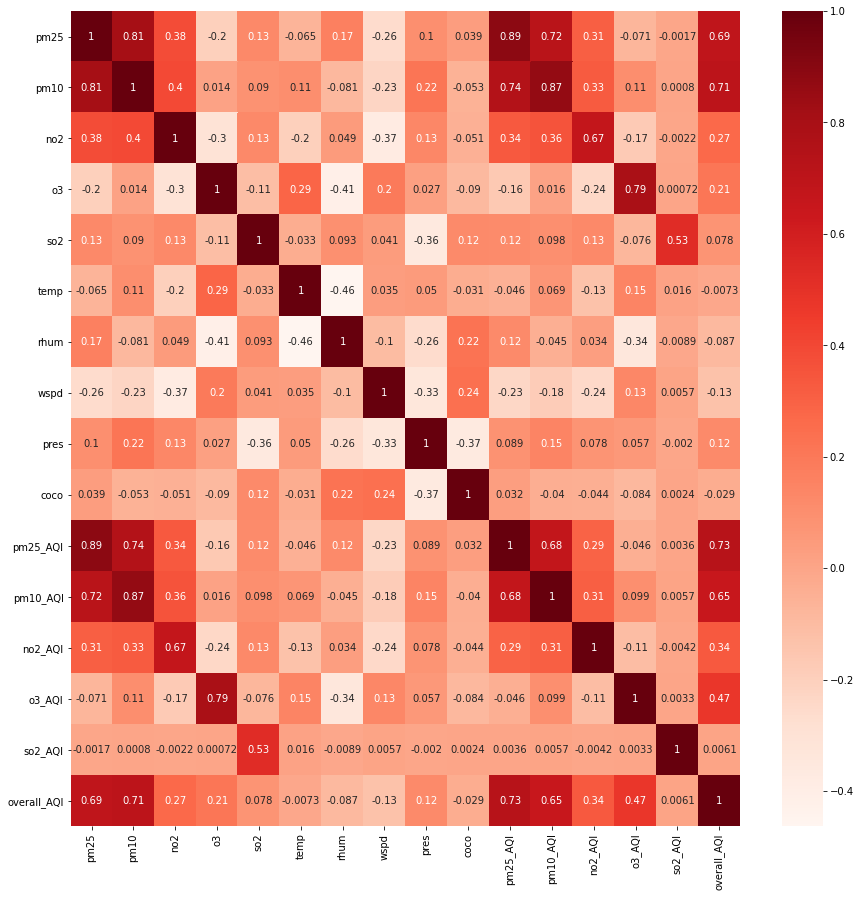

In [11]:
plt.figure(figsize=(15,15))
cor = final_df.corr(method='pearson')
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

## Spearman's rho

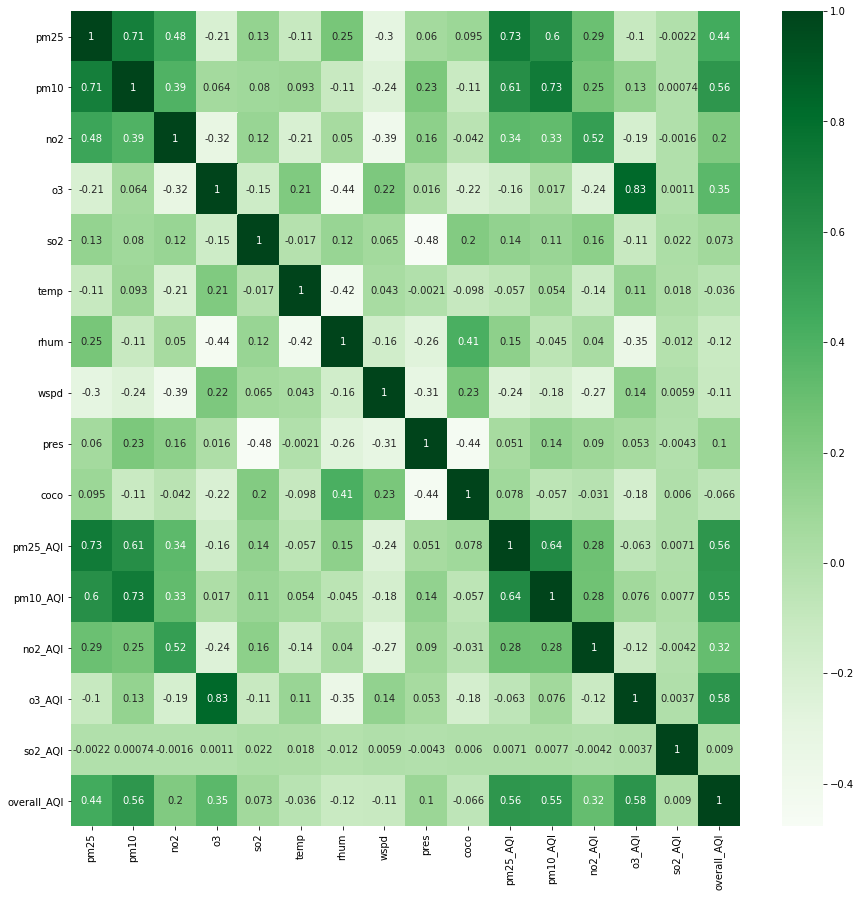

In [12]:
plt.figure(figsize=(15,15))
cor = final_df.corr(method='spearman')
sns.heatmap(cor, annot=True, cmap=plt.cm.Greens)
plt.show()

## Kendall's  tau

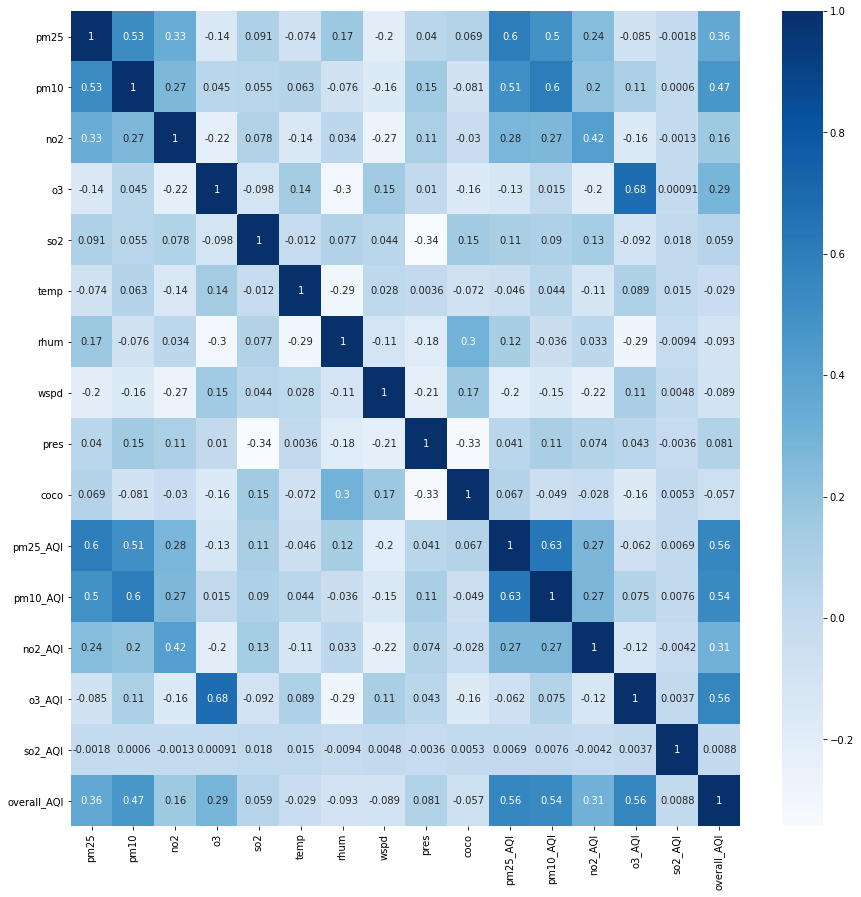

In [13]:
plt.figure(figsize=(15,15))
cor = final_df.corr(method='kendall')
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues)
plt.show()

# Data Preparation for Machine Learning Models

In [14]:
final_df.columns

Index(['pm25', 'pm10', 'no2', 'o3', 'so2', 'temp', 'rhum', 'wspd', 'pres',
       'coco', 'pm25_AQI', 'pm10_AQI', 'no2_AQI', 'o3_AQI', 'so2_AQI',
       'overall_AQI'],
      dtype='object')

In [15]:
dataset = final_df.copy()
dataset

,pm25,pm10,no2,o3,so2,temp,rhum,wspd,pres,coco,pm25_AQI,pm10_AQI,no2_AQI,o3_AQI,so2_AQI,overall_AQI
2020-05-10 01:00:00,16.306458,32.799999,31.402185,106.500000,4.333333,11.1,76.400002,3.1,1007.900024,3.0,2.0,2.0,1.0,3.0,1.0,3.0
2020-05-10 02:00:00,15.909375,32.500000,26.201515,105.666664,4.000000,10.3,80.900002,4.7,1007.400024,3.0,2.0,2.0,1.0,3.0,1.0,3.0
2020-05-10 03:00:00,16.222708,32.000000,27.301617,101.333336,5.500000,10.3,82.199997,8.0,1007.200012,3.0,2.0,2.0,1.0,3.0,1.0,3.0
2020-05-10 04:00:00,16.411041,31.250000,23.601511,98.333336,5.500000,10.0,82.500000,7.4,1006.799988,3.0,2.0,2.0,1.0,2.0,1.0,2.0
2020-05-10 05:00:00,17.006327,30.400000,21.637600,93.500000,4.666667,10.8,82.500000,7.8,1006.599976,3.0,2.0,2.0,1.0,2.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-01 20:00:00,8.200000,16.650000,44.653572,28.988890,3.216667,10.4,76.199997,11.9,1012.299988,2.0,1.0,1.0,2.0,1.0,1.0,2.0
2021-10-01 21:00:00,7.700000,15.710714,39.036587,30.576471,2.900000,10.0,77.500000,11.0,1012.400024,2.0,1.0,1.0,1.0,1.0,1.0,1.0
2021-10-01 22:00:00,6.194737,15.702564,35.688313,30.500000,2.650000,9.5,79.500000,10.1,1012.500000,2.0,1.0,1.0,1.0,1.0,1.0,1.0
2021-10-01 23:00:00,4.000000,11.000000,30.000000,37.000000,2.000000,9.3,81.000000,9.8,1012.299988,2.0,1.0,1.0,1.0,1.0,1.0,1.0


### Split data

In [16]:
from sklearn.model_selection import train_test_split

features=dataset.values
targets=dataset[["pm25", "pm10", "no2", "o3", "so2"]].values

X_train, X_test, y_train, y_test  = train_test_split(features, targets, test_size=0.1, random_state=1, shuffle=False)

X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.1, random_state=1, shuffle=False)

print("X_train:", X_train.shape)
print("X_test:", X_test.shape)

X_train: (9914, 16)
X_test: (1224, 16)


### Data Normalizaton

In [17]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)

X_val = scaler.transform(X_val)

X_test = scaler.transform(X_test)

X_train.shape, X_test.shape

((9914, 16), (1224, 16))

### Set up data with TimeseriesGenerator

In [18]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

win_length=12
batch_size=4
num_features=features.shape[1]

train_generator = TimeseriesGenerator(X_train, y_train, length=win_length, sampling_rate=1, batch_size=batch_size)
val_generator = TimeseriesGenerator(X_val, y_val, length=win_length, sampling_rate=1, batch_size=batch_size)
test_generator = TimeseriesGenerator(X_test, y_test, length=win_length, sampling_rate=1, batch_size=batch_size)

train_generator[0]

(array([[[0.15330605, 0.3836299 , 0.32239345, 0.6818182 , 0.03880597,
          0.4065657 , 0.69469595, 0.06004141, 0.521368  , 0.08      ,
          0.2       , 0.33333334, 0.        , 0.6666666 , 0.        ,
          0.40000004],
         [0.14895768, 0.37989324, 0.2689976 , 0.67648315, 0.0358209 ,
          0.38636366, 0.7529107 , 0.0931677 , 0.514246  , 0.08      ,
          0.2       , 0.33333334, 0.        , 0.6666666 , 0.        ,
          0.40000004],
         [0.15238893, 0.37366548, 0.28029245, 0.64874095, 0.04925374,
          0.38636366, 0.76972824, 0.16149068, 0.5113964 , 0.08      ,
          0.2       , 0.33333334, 0.        , 0.6666666 , 0.        ,
          0.40000004],
         [0.15445133, 0.36432385, 0.24230309, 0.6295348 , 0.04925374,
          0.3787879 , 0.7736092 , 0.14906833, 0.5056982 , 0.08      ,
          0.2       , 0.33333334, 0.        , 0.33333334, 0.        ,
          0.2       ],
         [0.16097017, 0.35373664, 0.2221394 , 0.59859157, 0.04179104

### Create LSTM model

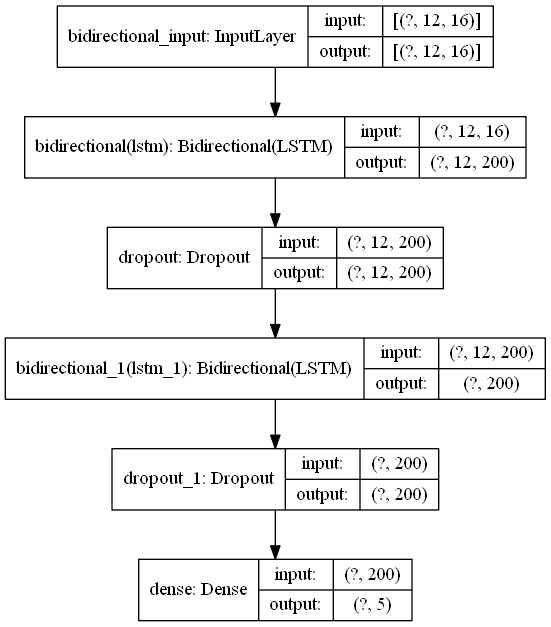

In [19]:
model_LSTM = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100,  return_sequences=True), input_shape=(win_length, num_features)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences=False)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(targets.shape[1])
])

model_LSTM.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001),loss=tf.losses.MeanSquaredLogarithmicError())

tf.keras.utils.plot_model(model=model_LSTM, show_shapes=True)

### Fit model

In [20]:
lr_monitor = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.5, cooldown=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)

with tf.device('/GPU:0'):
    prepared_model = model_LSTM.fit(train_generator, 
                                    validation_data=val_generator,
                                    epochs=200, 
                                    shuffle=False,  
                                    callbacks=[lr_monitor, early_stopping])

Epoch 1/200
2476/2476 [==============================] - 31s 12ms/step - loss: 0.3435 - val_loss: 0.1661
Epoch 2/200
2476/2476 [==============================] - 29s 12ms/step - loss: 0.2992 - val_loss: 0.1525
Epoch 3/200
2476/2476 [==============================] - 29s 12ms/step - loss: 0.2609 - val_loss: 0.1100
Epoch 4/200
2476/2476 [==============================] - 29s 12ms/step - loss: 0.2266 - val_loss: 0.1075
Epoch 5/200
2476/2476 [==============================] - 30s 12ms/step - loss: 0.2107 - val_loss: 0.0977
Epoch 6/200
2476/2476 [==============================] - 30s 12ms/step - loss: 0.1952 - val_loss: 0.0952
Epoch 7/200
2476/2476 [==============================] - 29s 12ms/step - loss: 0.1811 - val_loss: 0.0751
Epoch 8/200
2476/2476 [==============================] - 29s 12ms/step - loss: 0.1567 - val_loss: 0.0633
Epoch 9/200
2476/2476 [==============================] - 29s 12ms/step - loss: 0.1512 - val_loss: 0.0597
Epoch 10/200
2476/2476 [==============================]

Text(0, 0.5, 'mse score')

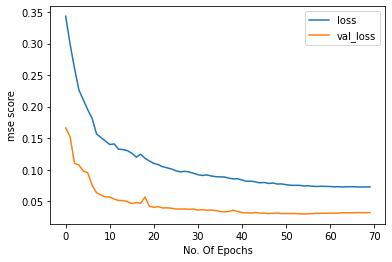

In [21]:
plt.plot(prepared_model.history["loss"],label="loss")
plt.plot(prepared_model.history["val_loss"],label="val_loss")
plt.legend(loc="best")
plt.xlabel("No. Of Epochs")
plt.ylabel("mse score")

In [22]:
model_LSTM.evaluate(test_generator, verbose=1)

303/303 [==============================] - 1s 5ms/step - loss: 0.0290


0.028985420241951942

### Get Predictions for new cases

In [23]:
predictions=model_LSTM.predict(test_generator)

pd.DataFrame(predictions)

,0,1,2,3,4
0,5.697437,11.282074,23.867836,29.317661,2.864380
1,6.403858,13.279594,23.227905,30.530392,2.796074
2,6.526249,13.608873,21.998796,32.504707,3.028637
3,6.105226,12.580320,22.196089,33.245724,2.716258
4,5.985742,12.071697,21.714266,34.140823,2.466084
...,...,...,...,...,...
1207,6.685144,13.521248,43.400394,34.531696,3.384104
1208,7.982765,15.445171,43.234325,31.324989,3.267410
1209,7.744258,15.292917,37.681946,32.957306,3.142292
1210,7.166938,14.504354,34.956924,32.620121,2.961906


In [24]:
df_pred=pd.DataFrame(X_test[:,:][win_length:])

rev_trans=scaler.inverse_transform(df_pred)

df_final=dataset[rev_trans.shape[0]*-1:]
df_final

,pm25,pm10,no2,o3,so2,temp,rhum,wspd,pres,coco,pm25_AQI,pm10_AQI,no2_AQI,o3_AQI,so2_AQI,overall_AQI
2021-08-12 13:00:00,6.330435,14.544642,21.377108,28.011765,2.883333,19.700001,78.699997,17.100000,1018.700012,4.0,1.0,1.0,1.0,1.0,1.0,1.0
2021-08-12 14:00:00,6.617391,13.942857,20.484337,29.770588,3.340000,19.799999,77.900002,21.400000,1018.700012,4.0,1.0,1.0,1.0,1.0,1.0,1.0
2021-08-12 15:00:00,5.734783,12.921429,20.624096,30.076471,2.750000,20.400000,74.699997,20.299999,1018.500000,4.0,1.0,1.0,1.0,1.0,1.0,1.0
2021-08-12 16:00:00,5.813044,12.261818,20.622892,31.382353,2.650000,20.400000,73.000000,21.900000,1018.000000,4.0,1.0,1.0,1.0,1.0,1.0,1.0
2021-08-12 17:00:00,5.756522,11.750909,18.353659,32.741177,3.220000,20.500000,71.199997,21.900000,1018.400024,3.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-01 20:00:00,8.200000,16.650000,44.653572,28.988890,3.216667,10.400000,76.199997,11.900000,1012.299988,2.0,1.0,1.0,2.0,1.0,1.0,2.0
2021-10-01 21:00:00,7.700000,15.710714,39.036587,30.576471,2.900000,10.000000,77.500000,11.000000,1012.400024,2.0,1.0,1.0,1.0,1.0,1.0,1.0
2021-10-01 22:00:00,6.194737,15.702564,35.688313,30.500000,2.650000,9.500000,79.500000,10.100000,1012.500000,2.0,1.0,1.0,1.0,1.0,1.0,1.0
2021-10-01 23:00:00,4.000000,11.000000,30.000000,37.000000,2.000000,9.300000,81.000000,9.800000,1012.299988,2.0,1.0,1.0,1.0,1.0,1.0,1.0


In [25]:
df_final[["pm25_pred", "pm10_pred", "no2_pred", "o3_pred", "so2_pred"]]=predictions
df_final

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,pm25,pm10,no2,o3,so2,temp,rhum,wspd,pres,coco,...,pm10_AQI,no2_AQI,o3_AQI,so2_AQI,overall_AQI,pm25_pred,pm10_pred,no2_pred,o3_pred,so2_pred
2021-08-12 13:00:00,6.330435,14.544642,21.377108,28.011765,2.883333,19.700001,78.699997,17.100000,1018.700012,4.0,...,1.0,1.0,1.0,1.0,1.0,5.697437,11.282074,23.867836,29.317661,2.864380
2021-08-12 14:00:00,6.617391,13.942857,20.484337,29.770588,3.340000,19.799999,77.900002,21.400000,1018.700012,4.0,...,1.0,1.0,1.0,1.0,1.0,6.403858,13.279594,23.227905,30.530392,2.796074
2021-08-12 15:00:00,5.734783,12.921429,20.624096,30.076471,2.750000,20.400000,74.699997,20.299999,1018.500000,4.0,...,1.0,1.0,1.0,1.0,1.0,6.526249,13.608873,21.998796,32.504707,3.028637
2021-08-12 16:00:00,5.813044,12.261818,20.622892,31.382353,2.650000,20.400000,73.000000,21.900000,1018.000000,4.0,...,1.0,1.0,1.0,1.0,1.0,6.105226,12.580320,22.196089,33.245724,2.716258
2021-08-12 17:00:00,5.756522,11.750909,18.353659,32.741177,3.220000,20.500000,71.199997,21.900000,1018.400024,3.0,...,1.0,1.0,1.0,1.0,1.0,5.985742,12.071697,21.714266,34.140823,2.466084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-01 20:00:00,8.200000,16.650000,44.653572,28.988890,3.216667,10.400000,76.199997,11.900000,1012.299988,2.0,...,1.0,2.0,1.0,1.0,2.0,6.685144,13.521248,43.400394,34.531696,3.384104
2021-10-01 21:00:00,7.700000,15.710714,39.036587,30.576471,2.900000,10.000000,77.500000,11.000000,1012.400024,2.0,...,1.0,1.0,1.0,1.0,1.0,7.982765,15.445171,43.234325,31.324989,3.267410
2021-10-01 22:00:00,6.194737,15.702564,35.688313,30.500000,2.650000,9.500000,79.500000,10.100000,1012.500000,2.0,...,1.0,1.0,1.0,1.0,1.0,7.744258,15.292917,37.681946,32.957306,3.142292
2021-10-01 23:00:00,4.000000,11.000000,30.000000,37.000000,2.000000,9.300000,81.000000,9.800000,1012.299988,2.0,...,1.0,1.0,1.0,1.0,1.0,7.166938,14.504354,34.956924,32.620121,2.961906


<AxesSubplot:>

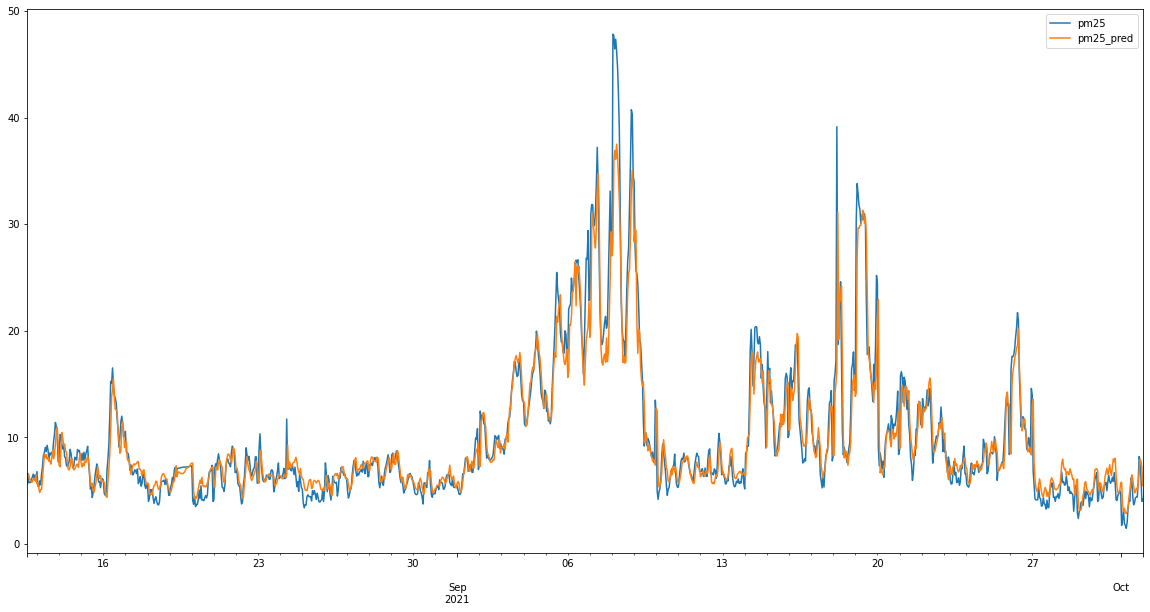

In [26]:
df_final[["pm25","pm25_pred"]].plot(figsize=(20,10))

<AxesSubplot:>

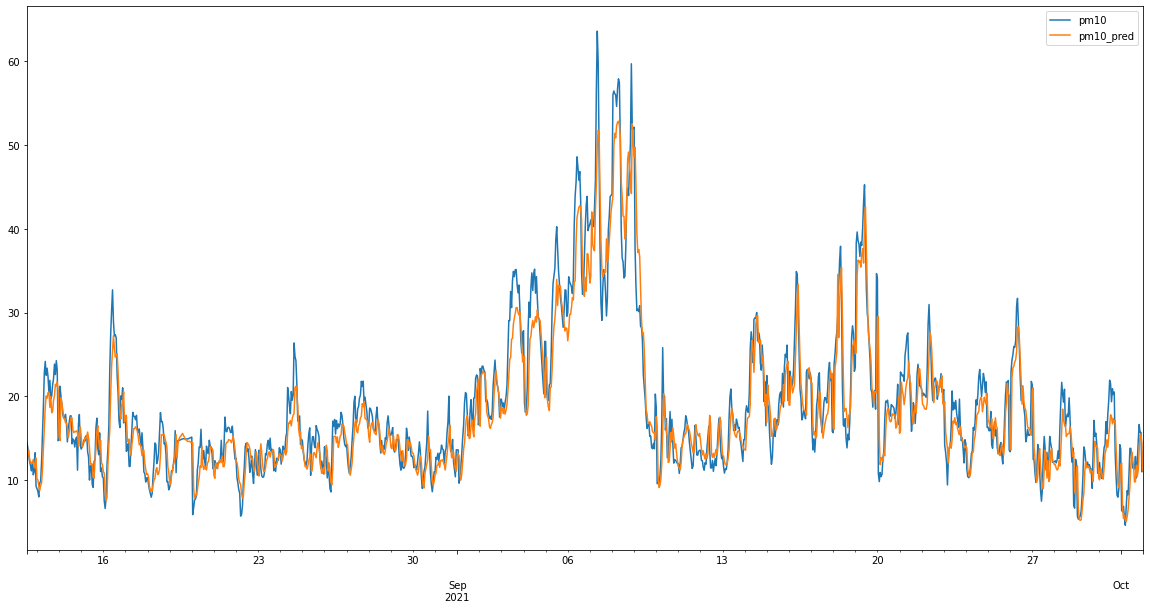

In [27]:
df_final[["pm10","pm10_pred"]].plot(figsize=(20,10))

<AxesSubplot:>

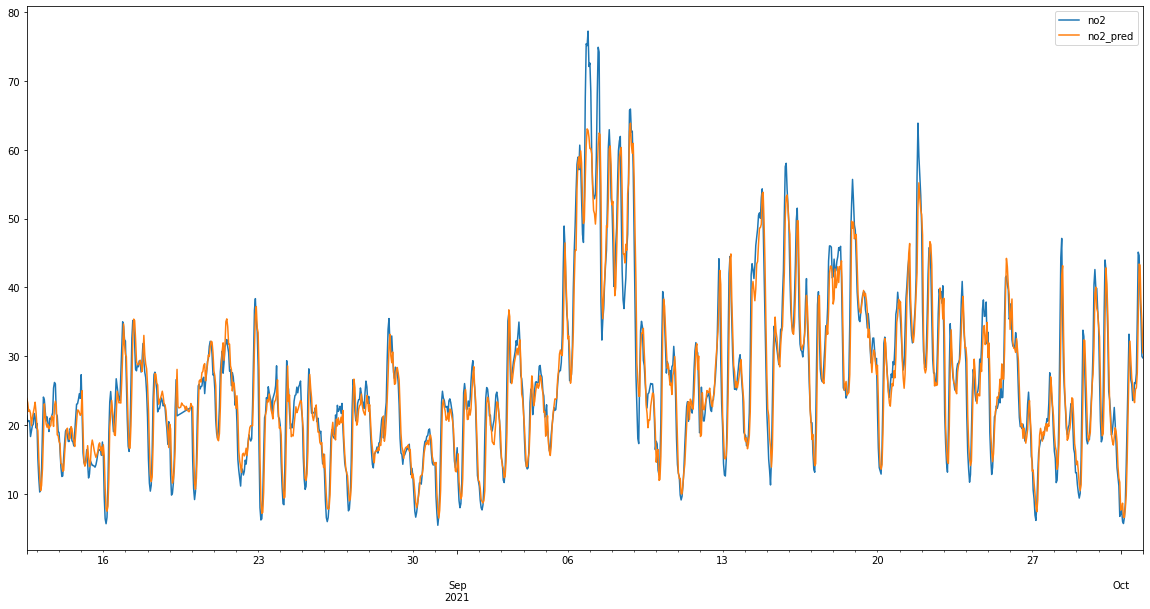

In [28]:
df_final[["no2","no2_pred"]].plot(figsize=(20,10))

<AxesSubplot:>

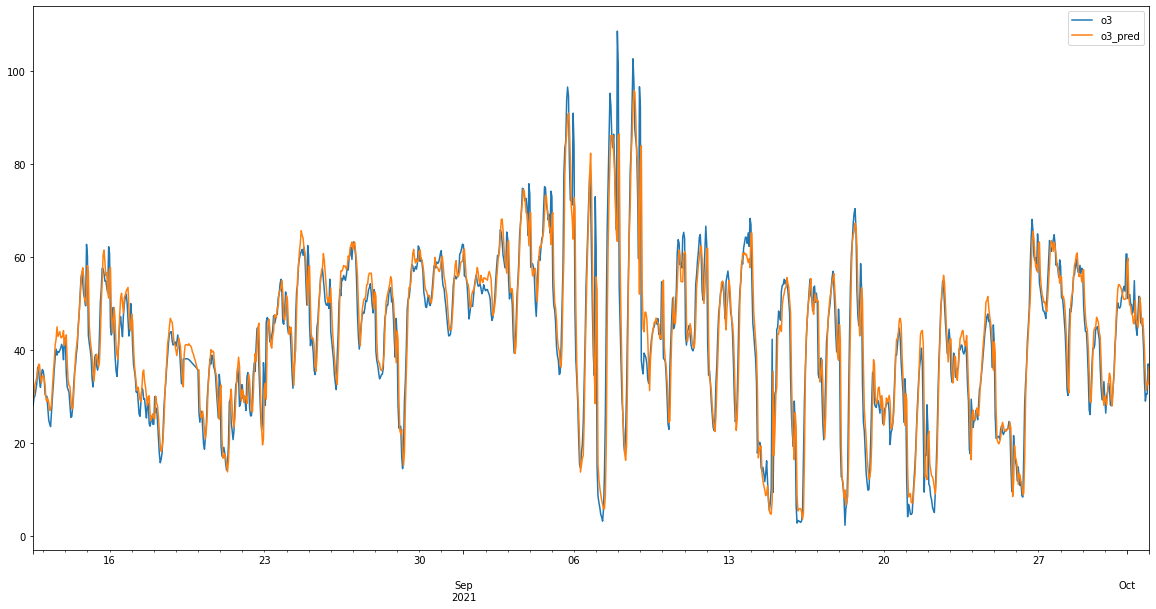

In [29]:
df_final[["o3","o3_pred"]].plot(figsize=(20,10))

<AxesSubplot:>

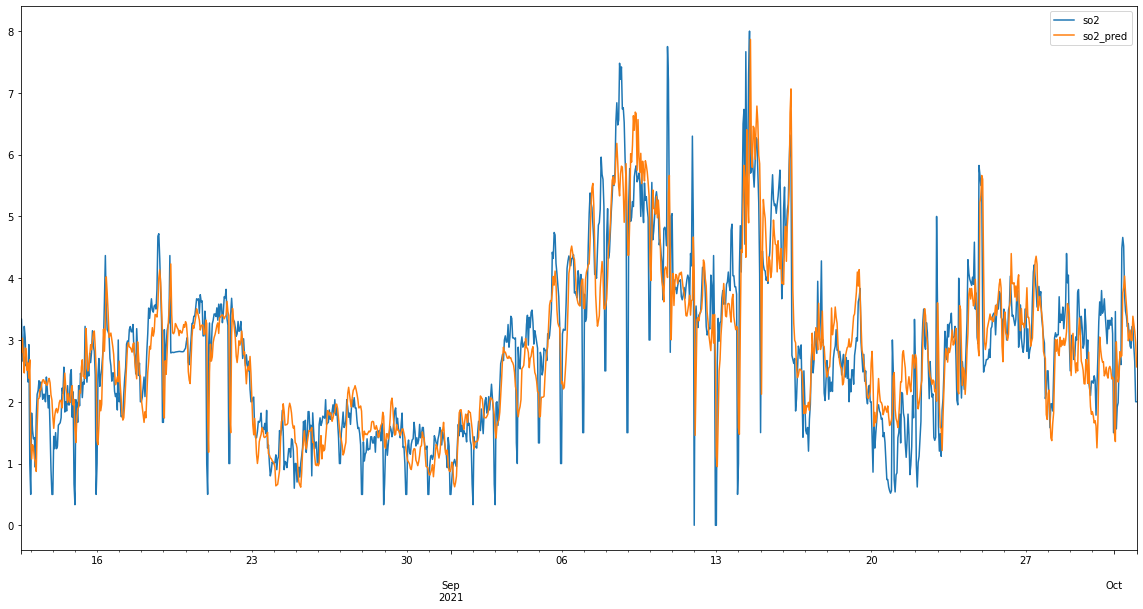

In [30]:
df_final[["so2","so2_pred"]].plot(figsize=(20,10))

### Create CNN Model

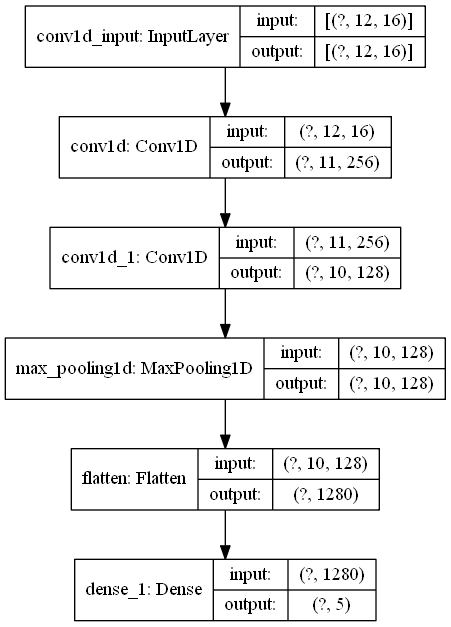

In [31]:
model_CNN = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=256, kernel_size=2, activation=tf.keras.layers.LeakyReLU(alpha=0.3), input_shape=(win_length, num_features)),
    tf.keras.layers.Conv1D(filters=128, kernel_size=2, activation=tf.keras.layers.LeakyReLU(alpha=0.3)),
    tf.keras.layers.MaxPooling1D(pool_size=1),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(targets.shape[1])
])

model_CNN.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001),loss=tf.losses.MeanSquaredLogarithmicError())

tf.keras.utils.plot_model(model=model_CNN, show_shapes=True)

### Fit model

In [32]:
lr_monitor = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.5, cooldown=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)

with tf.device('/GPU:0'):
    prepared_model_CNN = model_CNN.fit(train_generator, 
                                       validation_data=val_generator,
                                       epochs=400, 
                                       shuffle=False,  
                                       callbacks=[lr_monitor, early_stopping])

Epoch 1/400
2476/2476 [==============================] - 10s 4ms/step - loss: 3.0242 - val_loss: 2.9884
Epoch 2/400
2476/2476 [==============================] - 10s 4ms/step - loss: 0.4627 - val_loss: 0.1106
Epoch 3/400
2476/2476 [==============================] - 10s 4ms/step - loss: 0.1429 - val_loss: 0.0946
Epoch 4/400
2476/2476 [==============================] - 10s 4ms/step - loss: 0.1286 - val_loss: 0.0826
Epoch 5/400
2476/2476 [==============================] - 10s 4ms/step - loss: 0.1160 - val_loss: 0.0762
Epoch 6/400
2476/2476 [==============================] - 10s 4ms/step - loss: 0.1114 - val_loss: 0.0753
Epoch 7/400
2476/2476 [==============================] - 10s 4ms/step - loss: 0.1138 - val_loss: 0.0649
Epoch 8/400
2476/2476 [==============================] - 10s 4ms/step - loss: 0.1067 - val_loss: 0.0653
Epoch 9/400
2476/2476 [==============================] - 10s 4ms/step - loss: 0.1024 - val_loss: 0.0608
Epoch 10/400
2476/2476 [==============================] - 11s 4m

Text(0, 0.5, 'mse score')

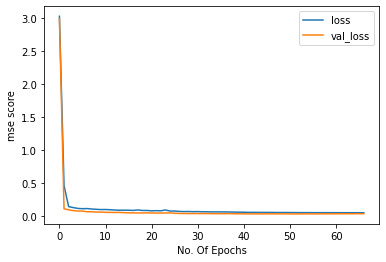

In [33]:
plt.plot(prepared_model_CNN.history["loss"],label="loss")
plt.plot(prepared_model_CNN.history["val_loss"],label="val_loss")
plt.legend(loc="best")
plt.xlabel("No. Of Epochs")
plt.ylabel("mse score")

In [34]:
model_CNN.evaluate(test_generator, verbose=1)

303/303 [==============================] - 1s 2ms/step - loss: 0.0272


0.027185635641217232

### Get Predictions for new cases

In [35]:
predictions=model_CNN.predict(test_generator)

pd.DataFrame(predictions)

,0,1,2,3,4
0,5.691132,12.373682,22.790983,30.454985,2.894863
1,6.439865,13.696468,20.337931,31.057302,2.935992
2,6.516709,13.798124,21.990225,33.749290,3.075079
3,5.821643,12.994314,19.583887,33.620083,2.916601
4,5.860898,12.465807,21.214808,34.716991,2.892302
...,...,...,...,...,...
1207,6.282717,14.545245,46.768650,32.979313,3.321268
1208,7.558049,16.574665,39.123341,29.469114,3.329222
1209,7.467974,16.036161,36.120823,30.381294,3.111115
1210,6.393335,16.107267,32.731995,31.469881,3.047744


In [36]:
df_pred=pd.DataFrame(X_test[:,:][win_length:])

rev_trans=scaler.inverse_transform(df_pred)

df_final=dataset[rev_trans.shape[0]*-1:]
df_final

,pm25,pm10,no2,o3,so2,temp,rhum,wspd,pres,coco,pm25_AQI,pm10_AQI,no2_AQI,o3_AQI,so2_AQI,overall_AQI
2021-08-12 13:00:00,6.330435,14.544642,21.377108,28.011765,2.883333,19.700001,78.699997,17.100000,1018.700012,4.0,1.0,1.0,1.0,1.0,1.0,1.0
2021-08-12 14:00:00,6.617391,13.942857,20.484337,29.770588,3.340000,19.799999,77.900002,21.400000,1018.700012,4.0,1.0,1.0,1.0,1.0,1.0,1.0
2021-08-12 15:00:00,5.734783,12.921429,20.624096,30.076471,2.750000,20.400000,74.699997,20.299999,1018.500000,4.0,1.0,1.0,1.0,1.0,1.0,1.0
2021-08-12 16:00:00,5.813044,12.261818,20.622892,31.382353,2.650000,20.400000,73.000000,21.900000,1018.000000,4.0,1.0,1.0,1.0,1.0,1.0,1.0
2021-08-12 17:00:00,5.756522,11.750909,18.353659,32.741177,3.220000,20.500000,71.199997,21.900000,1018.400024,3.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-01 20:00:00,8.200000,16.650000,44.653572,28.988890,3.216667,10.400000,76.199997,11.900000,1012.299988,2.0,1.0,1.0,2.0,1.0,1.0,2.0
2021-10-01 21:00:00,7.700000,15.710714,39.036587,30.576471,2.900000,10.000000,77.500000,11.000000,1012.400024,2.0,1.0,1.0,1.0,1.0,1.0,1.0
2021-10-01 22:00:00,6.194737,15.702564,35.688313,30.500000,2.650000,9.500000,79.500000,10.100000,1012.500000,2.0,1.0,1.0,1.0,1.0,1.0,1.0
2021-10-01 23:00:00,4.000000,11.000000,30.000000,37.000000,2.000000,9.300000,81.000000,9.800000,1012.299988,2.0,1.0,1.0,1.0,1.0,1.0,1.0


In [37]:
df_final[["pm25_pred", "pm10_pred", "no2_pred", "o3_pred", "so2_pred"]]=predictions
df_final

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,pm25,pm10,no2,o3,so2,temp,rhum,wspd,pres,coco,...,pm10_AQI,no2_AQI,o3_AQI,so2_AQI,overall_AQI,pm25_pred,pm10_pred,no2_pred,o3_pred,so2_pred
2021-08-12 13:00:00,6.330435,14.544642,21.377108,28.011765,2.883333,19.700001,78.699997,17.100000,1018.700012,4.0,...,1.0,1.0,1.0,1.0,1.0,5.691132,12.373682,22.790983,30.454985,2.894863
2021-08-12 14:00:00,6.617391,13.942857,20.484337,29.770588,3.340000,19.799999,77.900002,21.400000,1018.700012,4.0,...,1.0,1.0,1.0,1.0,1.0,6.439865,13.696468,20.337931,31.057302,2.935992
2021-08-12 15:00:00,5.734783,12.921429,20.624096,30.076471,2.750000,20.400000,74.699997,20.299999,1018.500000,4.0,...,1.0,1.0,1.0,1.0,1.0,6.516709,13.798124,21.990225,33.749290,3.075079
2021-08-12 16:00:00,5.813044,12.261818,20.622892,31.382353,2.650000,20.400000,73.000000,21.900000,1018.000000,4.0,...,1.0,1.0,1.0,1.0,1.0,5.821643,12.994314,19.583887,33.620083,2.916601
2021-08-12 17:00:00,5.756522,11.750909,18.353659,32.741177,3.220000,20.500000,71.199997,21.900000,1018.400024,3.0,...,1.0,1.0,1.0,1.0,1.0,5.860898,12.465807,21.214808,34.716991,2.892302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-01 20:00:00,8.200000,16.650000,44.653572,28.988890,3.216667,10.400000,76.199997,11.900000,1012.299988,2.0,...,1.0,2.0,1.0,1.0,2.0,6.282717,14.545245,46.768650,32.979313,3.321268
2021-10-01 21:00:00,7.700000,15.710714,39.036587,30.576471,2.900000,10.000000,77.500000,11.000000,1012.400024,2.0,...,1.0,1.0,1.0,1.0,1.0,7.558049,16.574665,39.123341,29.469114,3.329222
2021-10-01 22:00:00,6.194737,15.702564,35.688313,30.500000,2.650000,9.500000,79.500000,10.100000,1012.500000,2.0,...,1.0,1.0,1.0,1.0,1.0,7.467974,16.036161,36.120823,30.381294,3.111115
2021-10-01 23:00:00,4.000000,11.000000,30.000000,37.000000,2.000000,9.300000,81.000000,9.800000,1012.299988,2.0,...,1.0,1.0,1.0,1.0,1.0,6.393335,16.107267,32.731995,31.469881,3.047744


<AxesSubplot:>

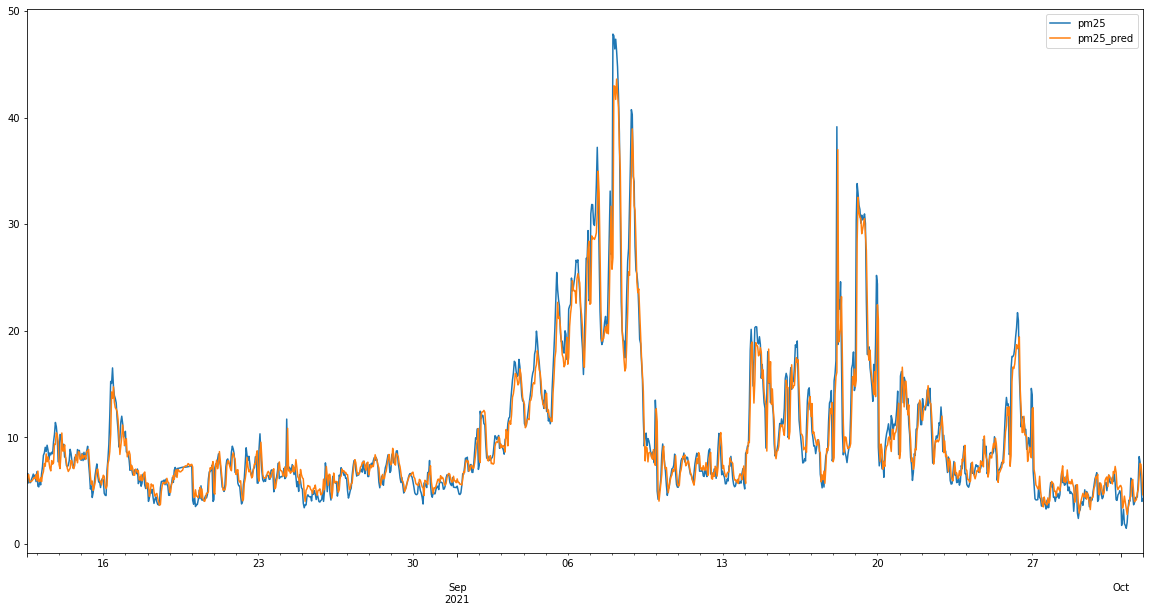

In [38]:
df_final[["pm25","pm25_pred"]].plot(figsize=(20,10))

<AxesSubplot:>

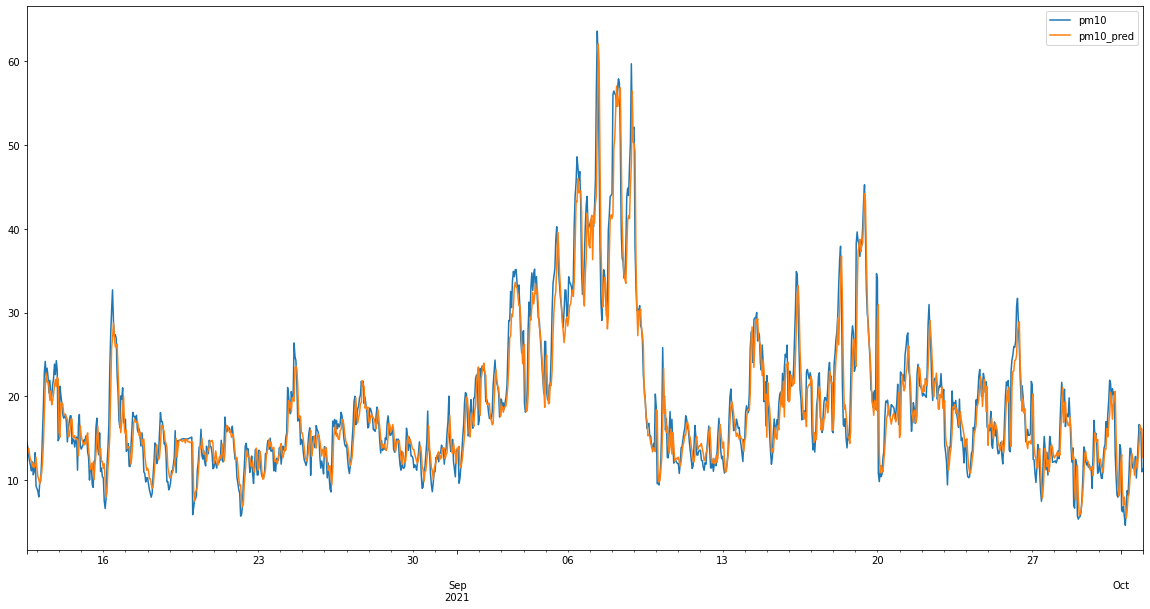

In [39]:
df_final[["pm10","pm10_pred"]].plot(figsize=(20,10))

<AxesSubplot:>

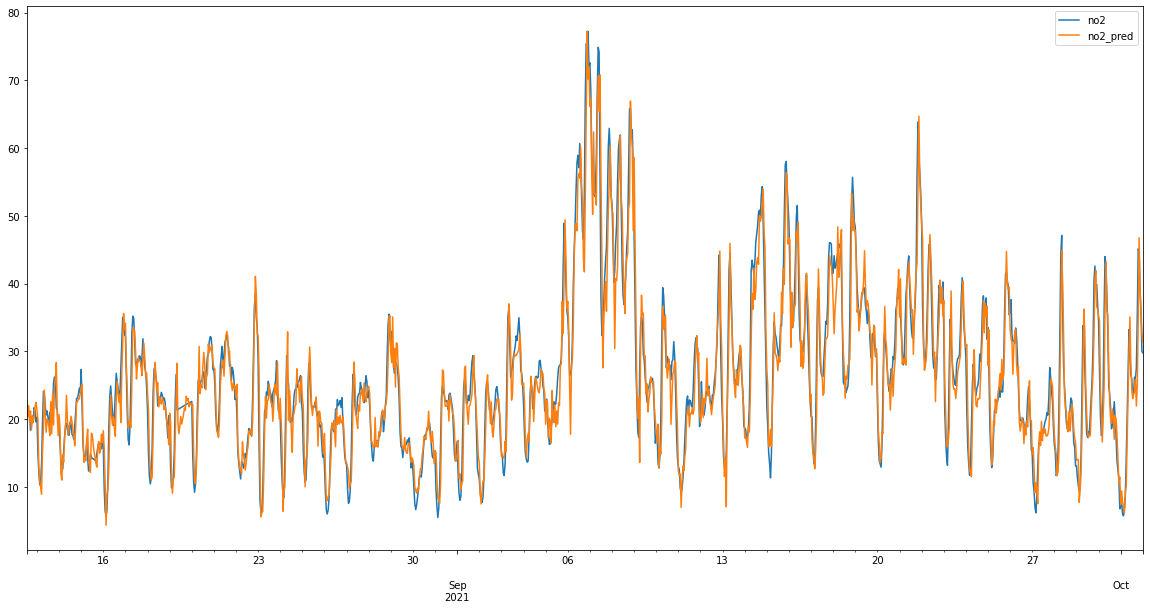

In [40]:
df_final[["no2","no2_pred"]].plot(figsize=(20,10))

<AxesSubplot:>

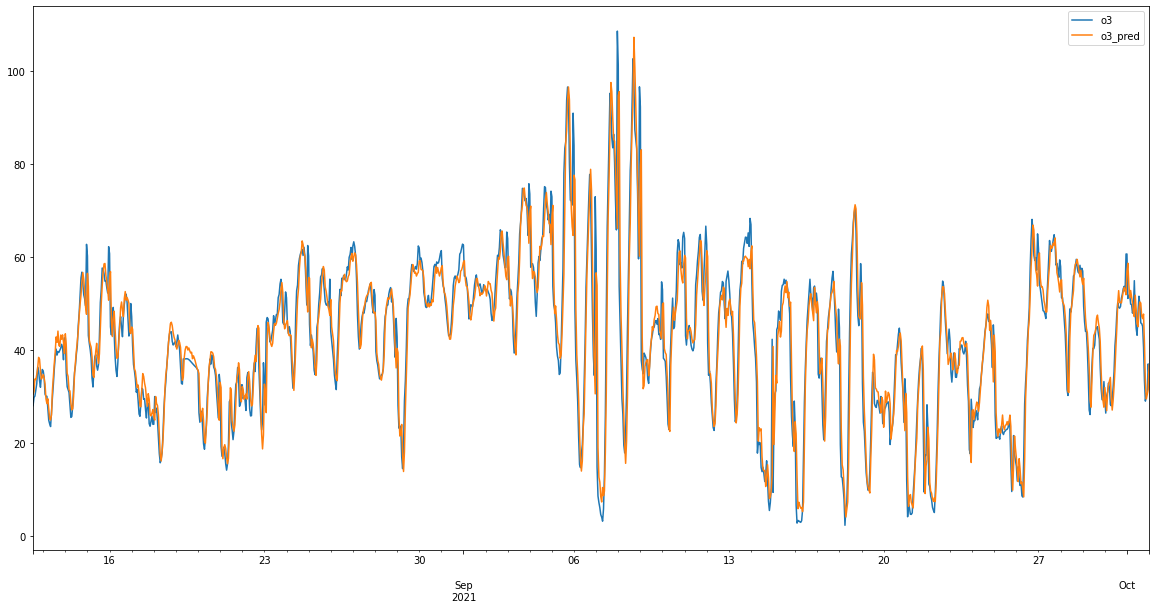

In [41]:
df_final[["o3","o3_pred"]].plot(figsize=(20,10))

<AxesSubplot:>

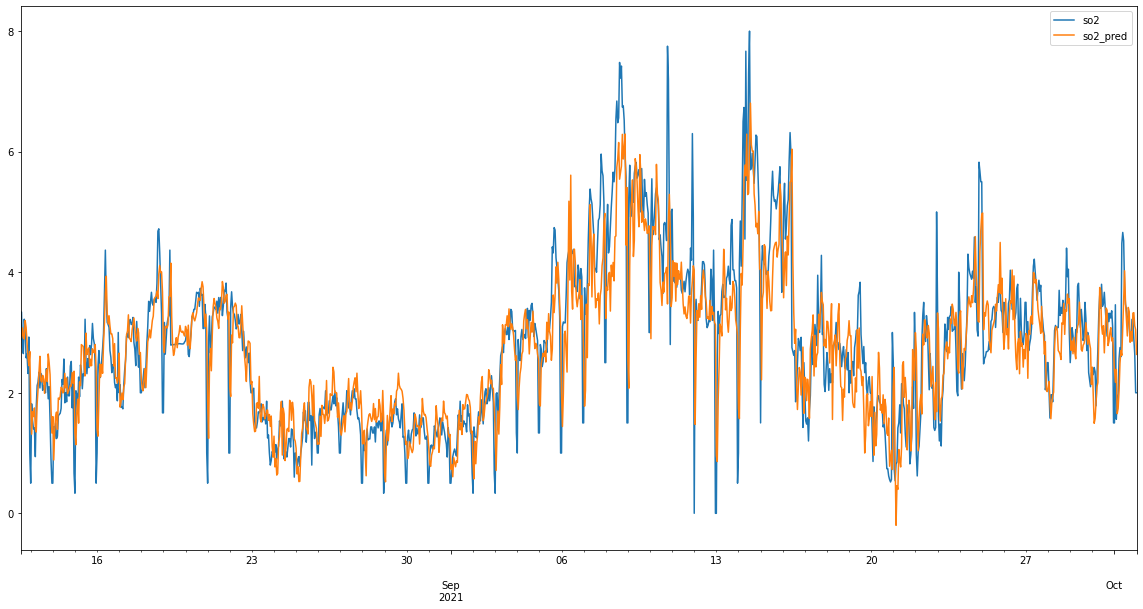

In [42]:
df_final[["so2","so2_pred"]].plot(figsize=(20,10))

# LSTM-CNN Model

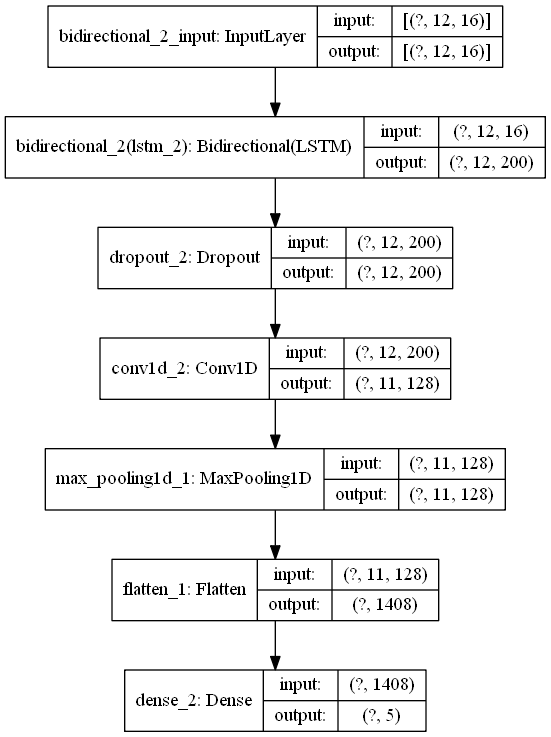

In [43]:
model_CNNLSTM = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences=True), input_shape=(win_length, num_features)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv1D(filters=128, kernel_size=2, activation=tf.keras.layers.LeakyReLU(alpha=0.7)),
    tf.keras.layers.MaxPooling1D(pool_size=1),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(targets.shape[1])
])

model_CNNLSTM.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001),loss=tf.losses.MeanSquaredLogarithmicError())

tf.keras.utils.plot_model(model=model_CNNLSTM, show_shapes=True)

In [44]:
model_CNNLSTM.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (None, 12, 200)           93600     
_________________________________________________________________
dropout_2 (Dropout)          (None, 12, 200)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 11, 128)           51328     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 11, 128)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1408)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 7045      
Total params: 151,973
Trainable params: 151,973
Non-trainable params: 0
________________________________________________

In [45]:
lr_monitor = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.5, cooldown=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)

with tf.device('/GPU:0'):
    prepared_model_CNNLSTM = model_CNNLSTM.fit(train_generator, 
                                       validation_data=val_generator,
                                       epochs=200, 
                                       shuffle=False,  
                                       callbacks=[lr_monitor, early_stopping])

Epoch 1/200
2476/2476 [==============================] - 24s 10ms/step - loss: 1.1718 - val_loss: 0.1740
Epoch 2/200
2476/2476 [==============================] - 23s 9ms/step - loss: 0.3410 - val_loss: 0.1476
Epoch 3/200
2476/2476 [==============================] - 23s 9ms/step - loss: 0.2732 - val_loss: 0.1001
Epoch 4/200
2476/2476 [==============================] - 23s 9ms/step - loss: 0.1610 - val_loss: 0.0828
Epoch 5/200
2476/2476 [==============================] - 23s 9ms/step - loss: 0.1295 - val_loss: 0.0731
Epoch 6/200
2476/2476 [==============================] - 23s 9ms/step - loss: 0.1247 - val_loss: 0.0697
Epoch 7/200
2476/2476 [==============================] - 23s 9ms/step - loss: 0.1167 - val_loss: 0.0621
Epoch 8/200
2476/2476 [==============================] - 23s 9ms/step - loss: 0.1152 - val_loss: 0.0587
Epoch 9/200
2476/2476 [==============================] - 23s 9ms/step - loss: 0.1125 - val_loss: 0.0586
Epoch 10/200
2476/2476 [==============================] - 23s 9

2476/2476 [==============================] - 25s 10ms/step - loss: 0.0645 - val_loss: 0.0262
Epoch 79/200
2476/2476 [==============================] - 23s 9ms/step - loss: 0.0640 - val_loss: 0.0262
Epoch 80/200
2476/2476 [==============================] - 23s 9ms/step - loss: 0.0645 - val_loss: 0.0264
Epoch 81/200
2476/2476 [==============================] - 23s 9ms/step - loss: 0.0635 - val_loss: 0.0264
Epoch 82/200
2476/2476 [==============================] - 23s 9ms/step - loss: 0.0642 - val_loss: 0.0264
Epoch 83/200
2476/2476 [==============================] - 23s 9ms/step - loss: 0.0642 - val_loss: 0.0266
Epoch 84/200
2476/2476 [==============================] - 23s 9ms/step - loss: 0.0640 - val_loss: 0.0267
Epoch 85/200
2476/2476 [==============================] - 24s 10ms/step - loss: 0.0634 - val_loss: 0.0267
Epoch 86/200
2476/2476 [==============================] - 23s 9ms/step - loss: 0.0644 - val_loss: 0.0268
Epoch 87/200
2476/2476 [==============================] - 23s 9ms/

Text(0, 0.5, 'mse score')

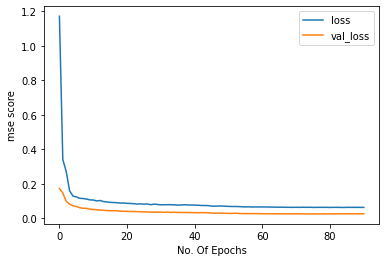

In [46]:
plt.plot(prepared_model_CNNLSTM.history["loss"],label="loss")
plt.plot(prepared_model_CNNLSTM.history["val_loss"],label="val_loss")
plt.legend(loc="best")
plt.xlabel("No. Of Epochs")
plt.ylabel("mse score")

In [47]:
model_CNNLSTM.evaluate(test_generator, verbose=1)

303/303 [==============================] - 1s 4ms/step - loss: 0.0256


0.025560254231095314

### Get Predictions for new cases

In [48]:
predictions=model_CNNLSTM.predict(test_generator)

pd.DataFrame(predictions)

,0,1,2,3,4
0,5.433317,12.163588,21.482513,28.259949,2.874533
1,6.090347,13.776757,20.387297,29.361876,2.872796
2,6.351660,13.716272,21.376276,30.789700,3.039785
3,5.709108,12.894325,20.378323,32.190327,2.864605
4,5.718292,12.462269,20.891865,33.119682,2.707618
...,...,...,...,...,...
1207,5.873859,14.184525,47.481030,34.090050,3.438850
1208,8.041388,16.437254,43.709023,29.976128,3.377543
1209,7.350774,15.610872,38.923973,29.466854,3.037456
1210,6.131431,15.247322,33.293221,29.343481,2.724394


In [49]:
df_pred=pd.DataFrame(X_test[:,:][win_length:])

rev_trans=scaler.inverse_transform(df_pred)

df_final=dataset[rev_trans.shape[0]*-1:]

df_final[["pm25_pred", "pm10_pred", "no2_pred", "o3_pred", "so2_pred"]]=predictions

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<AxesSubplot:>

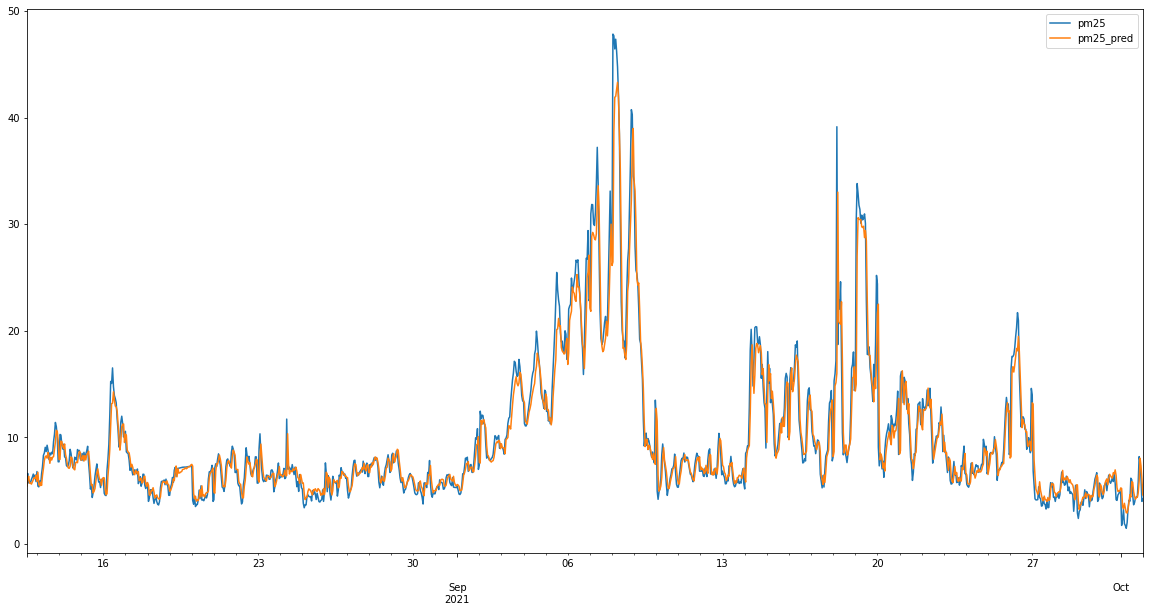

In [50]:
df_final[["pm25","pm25_pred"]].plot(figsize=(20,10))

<AxesSubplot:>

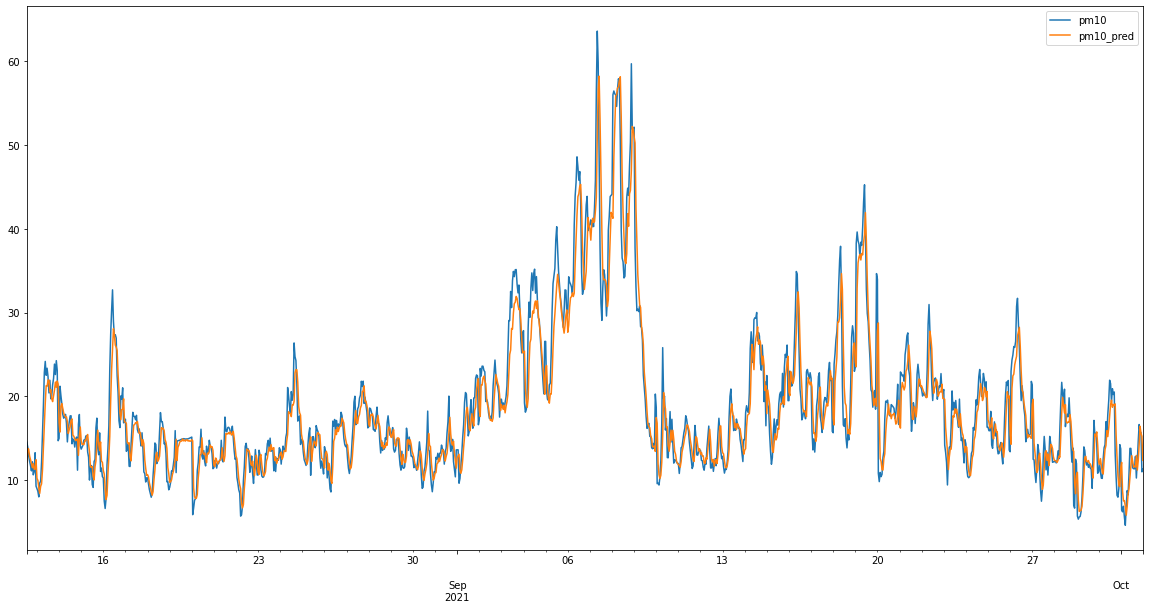

In [51]:
df_final[["pm10","pm10_pred"]].plot(figsize=(20,10))

<AxesSubplot:>

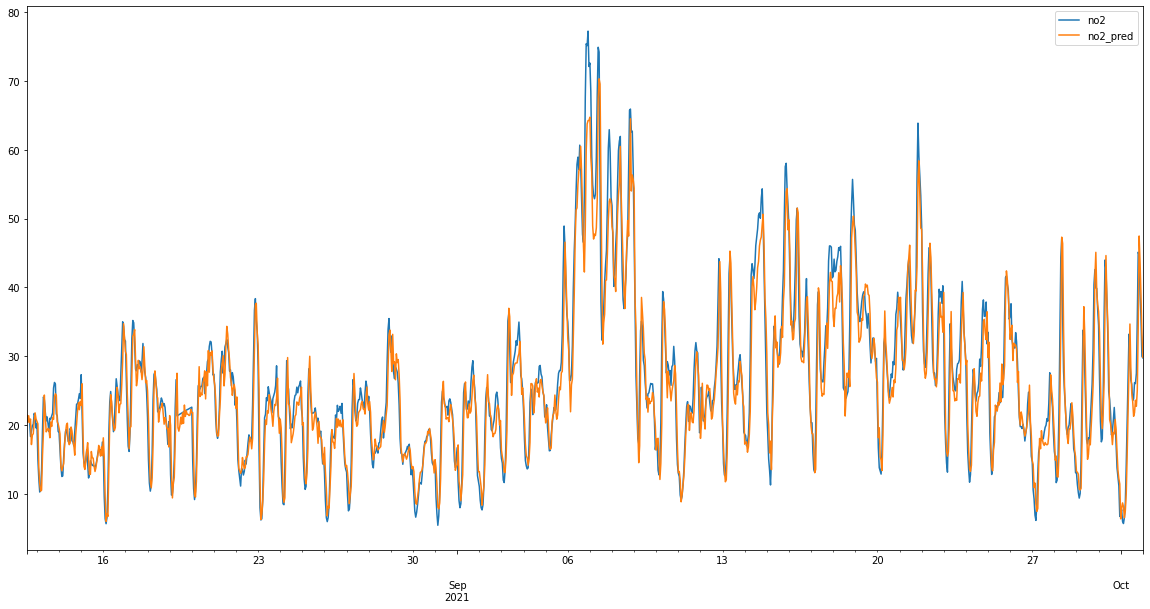

In [52]:
df_final[["no2","no2_pred"]].plot(figsize=(20,10))

<AxesSubplot:>

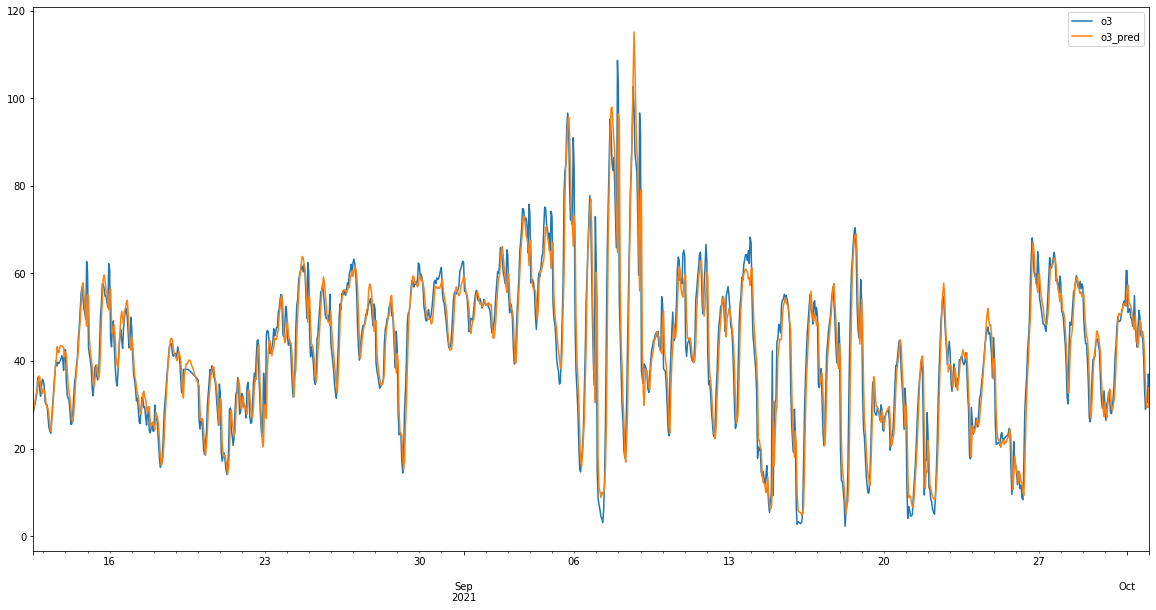

In [53]:
df_final[["o3","o3_pred"]].plot(figsize=(20,10))

<AxesSubplot:>

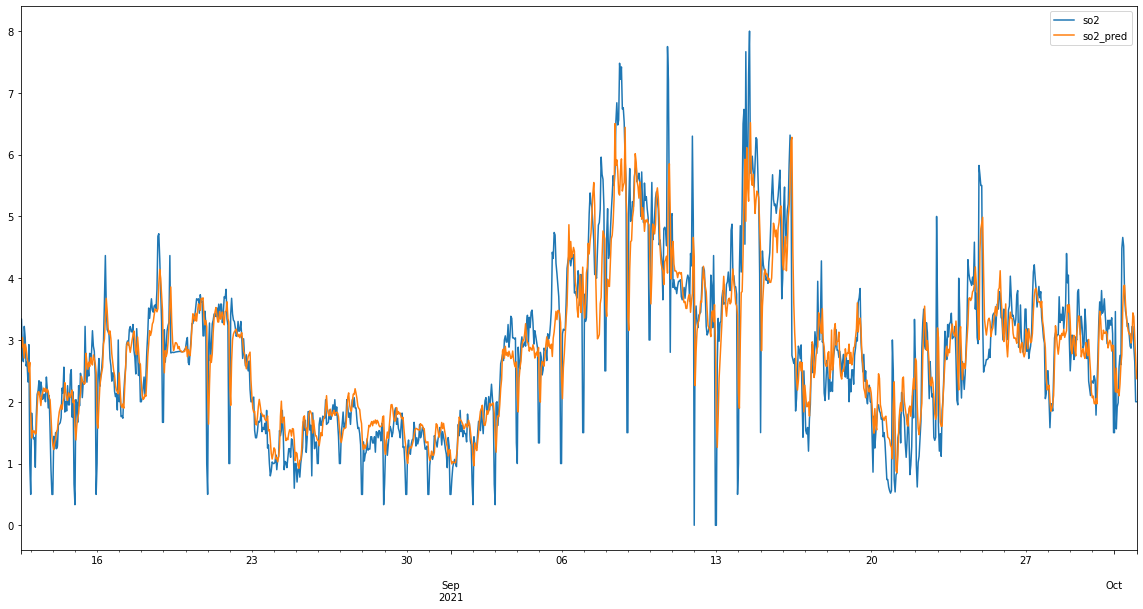

In [54]:
df_final[["so2","so2_pred"]].plot(figsize=(20,10))

In [55]:
def evaluate_preds(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    # Calculate various metrics
    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
    mslr = tf.keras.metrics.mean_squared_logarithmic_error(y_true, y_pred)
  
    return {"mae": mae.numpy(),
            "mse": mse.numpy(),
            "rmse": rmse.numpy(),
            "mape": mape.numpy(),
            "mslr": mslr.numpy(),
           }

In [56]:
selected_features = ["pm25", "pm10", "no2", "o3", "so2"]

for feature in selected_features:
    print("-----{}-----".format(feature))
    print(evaluate_preds(y_true=df_final[feature].values,
                         y_pred=df_final["{}_pred".format(feature)].values)
         )

-----pm25-----
{'mae': 1.0923272, 'mse': 3.8875856, 'rmse': 1.9716961, 'mape': 11.513667, 'mslr': 0.019832503}
-----pm10-----
{'mae': 2.0538678, 'mse': 8.987249, 'rmse': 2.9978743, 'mape': 11.449106, 'mslr': 0.020636564}
-----no2-----
{'mae': 2.616219, 'mse': 12.73817, 'rmse': 3.5690572, 'mape': 10.607514, 'mslr': 0.017542886}
-----o3-----
{'mae': 3.9191031, 'mse': 35.49808, 'rmse': 5.9580264, 'mape': 12.796105, 'mslr': 0.034837138}
-----so2-----
{'mae': 0.4209926, 'mse': 0.42073295, 'rmse': 0.6486393, 'mape': 7482244.5, 'mslr': 0.034952223}
